# Psychedelic experience data

Correlations among experience data and microstate statistics

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display
from pingouin.multicomp import multicomp
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA

from src.helpers import DATA_ROOT, PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")
plt.rcParams["legend.frameon"] = False

MS_STATS_ROOT = os.path.join(RESULTS_ROOT, "microstates")
WORKING_DIR = os.path.join(RESULTS_ROOT, "experience")
if not os.path.exists(WORKING_DIR):
    make_dirs(WORKING_DIR)
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "experience")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = False
PLOT_EXT = ".png"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_by"
PVAL_STARS = {0.01: "***", 0.05: "**", 0.1: "*"}

In [2]:
experience = pd.read_csv(
    os.path.join(DATA_ROOT, "experience_data", "experience_processed.csv")
)
experience = experience.rename(columns={"group": "condition"})

persisting_effs = pd.read_csv(
    os.path.join(
        DATA_ROOT, "experience_data", "persisting_effects_scale_processed.csv"
    )
)
persisting_effs = persisting_effs.rename(columns={"group": "condition"})

ms_inga = pd.read_csv("../results-inga-povilas/temporal_results.csv")
ms_inga[["condition", "subject", "time", "bull"]] = ms_inga[
    "DataSet"
].str.split("_", n=3, expand=True)
ms_inga = ms_inga.drop(
    [
        "DataSet",
        "bull",
        "Subject",
        "Group",
        "Condition",
        "Template",
        "SortInfo",
    ],
    axis=1,
)
ms_inga["subject"] = ms_inga["subject"].astype(int)
ms_inga["session"] = ms_inga["condition"] + "-" + ms_inga["time"]
ms_inga

,ExpVar,TotalTime,Duration_1,Duration_2,Duration_3,Duration_4,MeanDuration,Occurrence_1,Occurrence_2,Occurrence_3,...,DeltaTM_3->3,DeltaTM_3->4,DeltaTM_4->1,DeltaTM_4->2,DeltaTM_4->3,DeltaTM_4->4,condition,subject,time,session
0,0.781090,36.13672,0.038866,0.036591,0.034547,0.045850,0.039580,6.060318,6.254027,5.147119,...,NaN,0.005406,0.000257,0.004506,-0.004423,NaN,PLA,1,T1,PLA-T1
1,0.808344,36.35156,0.036003,0.039547,0.031429,0.047205,0.039685,5.584354,6.657210,4.814098,...,NaN,0.000187,-0.006350,0.007203,-0.000500,NaN,PLA,1,T2,PLA-T2
2,0.774093,36.48828,0.045609,0.040001,0.038616,0.043734,0.042134,5.919709,5.590836,5.508618,...,NaN,0.008130,-0.004762,0.014578,-0.010645,NaN,PLA,1,T3,PLA-T3
3,0.791479,36.19141,0.039567,0.036381,0.029904,0.042787,0.037897,5.774852,7.405073,4.890664,...,NaN,-0.007765,-0.007432,0.020738,-0.014023,NaN,PLA,1,T4,PLA-T4
4,0.792942,36.37891,0.040507,0.037712,0.037019,0.044282,0.040021,6.542253,5.882530,5.937507,...,NaN,0.004368,-0.000849,0.011981,-0.010840,NaN,PLA,1,T5,PLA-T5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.774101,36.72656,0.043157,0.040571,0.046265,0.048077,0.044734,5.091683,5.146139,6.099128,...,NaN,0.005097,-0.003408,-0.004305,0.006822,NaN,PSI,21,T1,PSI-T1
146,0.772291,35.32422,0.031088,0.023223,0.025638,0.035609,0.029910,8.860776,6.199712,7.388698,...,NaN,0.008491,0.010156,-0.010222,-0.000504,NaN,PSI,21,T2,PSI-T2
147,0.785702,36.08203,0.039669,0.034708,0.031975,0.039172,0.036743,7.676951,5.071777,6.568366,...,NaN,0.009610,0.012081,-0.002805,-0.008980,NaN,PSI,21,T3,PSI-T3
148,0.835024,37.26172,0.053360,0.042943,0.034536,0.073835,0.054476,5.608974,4.132928,2.871580,...,NaN,0.000547,0.016072,-0.002953,-0.012662,NaN,PSI,21,T4,PSI-T4


In [3]:
# to our format
lif = (
    ms_inga[
        [
            "session",
            "subject",
            "Duration_1",
            "Duration_2",
            "Duration_3",
            "Duration_4",
        ]
    ]
    .melt(
        id_vars=["session", "subject"],
        var_name="microstate",
        value_name="lifespan",
    )
    .replace(
        {
            "Duration_1": "A",
            "Duration_2": "B",
            "Duration_3": "C",
            "Duration_4": "D",
        }
    )
    .set_index(["subject", "session", "microstate"])
    .sort_index()
)

occ = (
    ms_inga[
        [
            "session",
            "subject",
            "Occurrence_1",
            "Occurrence_2",
            "Occurrence_3",
            "Occurrence_4",
        ]
    ]
    .melt(
        id_vars=["session", "subject"],
        var_name="microstate",
        value_name="occurrence",
    )
    .replace(
        {
            "Occurrence_1": "A",
            "Occurrence_2": "B",
            "Occurrence_3": "C",
            "Occurrence_4": "D",
        }
    )
    .set_index(["subject", "session", "microstate"])
    .sort_index()
)

cov = (
    ms_inga[
        [
            "session",
            "subject",
            "Contribution_1",
            "Contribution_2",
            "Contribution_3",
            "Contribution_4",
        ]
    ]
    .melt(
        id_vars=["session", "subject"],
        var_name="microstate",
        value_name="coverage",
    )
    .replace(
        {
            "Contribution_1": "A",
            "Contribution_2": "B",
            "Contribution_3": "C",
            "Contribution_4": "D",
        }
    )
    .set_index(["subject", "session", "microstate"])
    .sort_index()
)

var = (
    ms_inga[["session", "subject", "ExpVar"]]
    .set_index(["subject", "session"])
    .sort_index()
    .rename(columns={"ExpVar": "var_total"})
)

ms_stats = pd.merge(lif, occ, left_index=True, right_index=True)
ms_stats = pd.merge(ms_stats, cov, left_index=True, right_index=True)
ms_stats = pd.merge(
    ms_stats, var, left_index=True, right_index=True
).reset_index()
ms_stats["lifespan"] = ms_stats["lifespan"] * 1000.0
ms_stats[["condition", "time"]] = ms_stats["session"].str.split(
    "-", expand=True
)
ms_stats

,subject,session,microstate,lifespan,occurrence,coverage,var_total,condition,time
0,1,PLA-T1,A,38.86630,6.060318,0.235542,0.781090,PLA,T1
1,1,PLA-T1,B,36.59085,6.254027,0.228840,0.781090,PLA,T1
2,1,PLA-T1,C,34.54721,5.147119,0.177819,0.781090,PLA,T1
3,1,PLA-T1,D,45.84996,7.803697,0.357799,0.781090,PLA,T1
4,1,PLA-T2,A,36.00292,5.584354,0.201053,0.808344,PLA,T2
...,...,...,...,...,...,...,...,...,...
595,21,PSI-T4,D,73.83543,5.743160,0.424049,0.835024,PSI,T4
596,21,PSI-T5,A,45.99809,2.600601,0.119623,0.865771,PSI,T5
597,21,PSI-T5,B,64.13640,3.927439,0.251892,0.865771,PSI,T5
598,21,PSI-T5,C,40.80333,2.441381,0.099616,0.865771,PSI,T5


In [4]:
def pd_pca(df, n_comps, col_name=None):
    if col_name is None:
        col_name = ""
    else:
        col_name += "_"
    pca = PCA(n_components=n_comps)
    pcs = pca.fit_transform(df.values)
    return pd.DataFrame(
        pcs,
        index=df.index,
        columns=[
            f"{col_name}PC{i + 1}_{pca.explained_variance_ratio_[i]:.1%}"
            for i in range(n_comps)
        ],
    )


def plot_corr(
    df,
    method="pearson",
    title="",
    mask_upper=True,
    mask_pval=True,
    fname=None,
    lines=None,
):
    plt.figure(figsize=(16, 14))
    corr = df.corr(method=method)
    lines = lines or []

    def pval_func(x, y):
        if method == "pearson":
            return pearsonr(x, y)[1]
        elif method == "spearman":
            return spearmanr(x, y)[1]

    pval = df.corr(method=pval_func)
    mask_up = (
        np.triu(np.ones_like(corr, dtype=bool))
        if mask_upper
        else np.zeros_like(corr, dtype=bool)
    )
    mask_pval = pval > 0.05 if mask_pval else np.zeros_like(corr, dtype=bool)
    mask = np.logical_or(mask_up, mask_pval)
    sns.heatmap(
        corr,
        annot=df.rcorr(
            method=method,
            upper="pval",
            decimals=2,
            padjust=MULTI_CORRECTION,
            stars=True,
            pval_stars={0.01: "***", 0.05: "**", 0.1: "*"},
        ),
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        mask=mask,
        fmt="",
        cbar_kws={"shrink": 0.5},
    )
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.hlines(
        lines,
        *plt.gca().get_xlim(),
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.vlines(
        lines,
        *plt.gca().get_ylim(),
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.title(title)
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR, f"{fname}_{method}_correlation{PLOT_EXT}"
            ),
            bbox_inches="tight",
            transparent=True,
        )
        p = pval.applymap(replace_pval)
        corr = corr.round(5).astype(str) + p
        corr.to_csv(
            os.path.join(WORKING_DIR, f"{fname}_{method}_correlation.csv")
        )


def replace_pval(x, pval_stars=PVAL_STARS):
    for key, value in pval_stars.items():
        if x < key:
            return value
    return ""

## PLA vs PSI differences in ASC

In [5]:
df_experience = experience[experience["subject"].isin(ms_stats["subject"])]

ASC = ["AIA", "OSE", "VUS", "VWB"]
asc_ttest = pd.DataFrame()
for asc in ASC:
    tt = pg.ttest(
        df_experience[df_experience["condition"] == "PLA"][asc],
        df_experience[df_experience["condition"] == "PSI"][asc],
        paired=True,
    )
    tt.index = [asc]
    asc_ttest = pd.concat([asc_ttest, tt], axis=0)
asc_ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
AIA,-7.948990,14,two-sided,1.475204e-06,"[-0.39, -0.22]",2.841789,1.231e+04,1.0
OSE,-15.515978,14,two-sided,3.250762e-10,"[-0.77, -0.58]",5.044945,2.688e+07,1.0
VUS,-19.253664,14,two-sided,1.799575e-11,"[-0.8, -0.64]",7.071811,3.875e+08,1.0
VWB,-15.646270,14,two-sided,2.908987e-10,"[-0.55, -0.42]",5.538413,2.977e+07,1.0


## PLA vs PSI differences in BPRS

In [6]:
BP = list(experience.filter(like="BP").columns)

bprs_ttest = pd.DataFrame()
for bprs in BP:
    tt = pg.ttest(
        df_experience[df_experience["condition"] == "PLA"][bprs],
        df_experience[df_experience["condition"] == "PSI"][bprs],
        paired=True,
    )
    tt.index = [bprs]
    bprs_ttest = pd.concat([bprs_ttest, tt], axis=0)
bprs_ttest

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/parametric.py:243: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/effsize.py:809: RuntimeWarning: invalid value encountered in double_scalars
  d = (x.mean() - y.mean()) / np.sqrt((x.var(ddof=1) + y.var(ddof=1)) / 2)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
BP-5:FKT-I_T0,-0.179605,14,two-sided,0.860036,"[-0.86, 0.73]",0.058047,0.266,0.055059
BP-5:FKT-II_T0,0.0,14,two-sided,1.0,"[-0.36, 0.36]",0.0,0.262,0.05
BP-5:FKT-III_T0,NaN,14,two-sided,NaN,"[nan, nan]",NaN,nan,NaN
BP-5:FKT-IV_T0,1.0,14,two-sided,0.334282,"[-0.15, 0.42]",0.226145,0.403,0.129271
BP-5:FKT-V_T0,NaN,14,two-sided,NaN,"[nan, nan]",NaN,nan,NaN
BP-5:FKT-I_T70,-1.103355,14,two-sided,0.288478,"[-1.18, 0.38]",0.334664,0.441,0.226907
BP-5:FKT-II_T70,-4.680855,14,two-sided,0.000354,"[-5.54, -2.06]",1.507137,94.956,0.999713
BP-5:FKT-III_T70,-6.964097,14,two-sided,0.000007,"[-9.85, -5.21]",2.542929,3195.373,1.0
BP-5:FKT-IV_T70,-3.415062,14,two-sided,0.004186,"[-4.78, -1.09]",1.255132,11.482,0.994561
BP-5:FKT-V_T70,-2.357716,14,two-sided,0.033467,"[-2.29, -0.11]",0.860916,2.103,0.872552


In [7]:
df_pers_effs = persisting_effs[
    persisting_effs["subject"].isin(ms_stats["subject"])
]
cols = [
    "Attidues about Life positive",
    "Attidues about Life negative",
    "Attitudes about Self positive",
    "Attitudes about Self negative",
    "Mood Changes positive",
    "Mood Changes negative",
    "Relationships positive",
    "Relationships negative",
    "Behavioral Changes positive",
    "Behavioral Changes negative",
    "Spirituality positive",
    "Spirituality negative",
]
pers_ttest = pd.DataFrame()
for col in cols:
    tt = pg.ttest(
        df_pers_effs[df_pers_effs["condition"] == "PLA"][col].astype(float),
        df_pers_effs[df_pers_effs["condition"] == "PSI"][col].astype(float),
        paired=True,
    )
    tt.index = [col]
    pers_ttest = pd.concat([pers_ttest, tt], axis=0)
pers_ttest

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/parametric.py:243: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/effsize.py:809: RuntimeWarning: invalid value encountered in double_scalars
  d = (x.mean() - y.mean()) / np.sqrt((x.var(ddof=1) + y.var(ddof=1)) / 2)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Attidues about Life positive,-7.410061,14,two-sided,0.000003,"[-35.24, -19.42]",2.497958,5959.288,1.0
Attidues about Life negative,-3.538114,14,two-sided,0.003277,"[-3.75, -0.92]",1.251483,14.102,0.994355
Attitudes about Self positive,-6.326584,14,two-sided,0.000019,"[-27.41, -13.53]",2.127311,1263.263,1.0
Attitudes about Self negative,-1.074541,14,two-sided,0.300751,"[-1.6, 0.53]",0.354619,0.429,0.248938
Mood Changes positive,-6.484745,14,two-sided,0.000014,"[-23.95, -12.05]",2.160692,1596.811,1.0
Mood Changes negative,-0.987029,14,two-sided,0.340381,"[-1.9, 0.7]",0.35796,0.399,0.252741
Relationships positive,-5.896059,14,two-sided,0.000039,"[-19.09, -8.91]",1.88166,658.619,1.0
Relationships negative,-2.09165,14,two-sided,0.055178,"[-1.35, 0.02]",0.690066,1.425,0.700642
Behavioral Changes positive,-6.454126,14,two-sided,0.000015,"[-2.93, -1.47]",2.356713,1526.316,1.0
Behavioral Changes negative,NaN,14,two-sided,NaN,"[nan, nan]",NaN,nan,NaN


## Correlations within experience data

### Only psilocybin condition

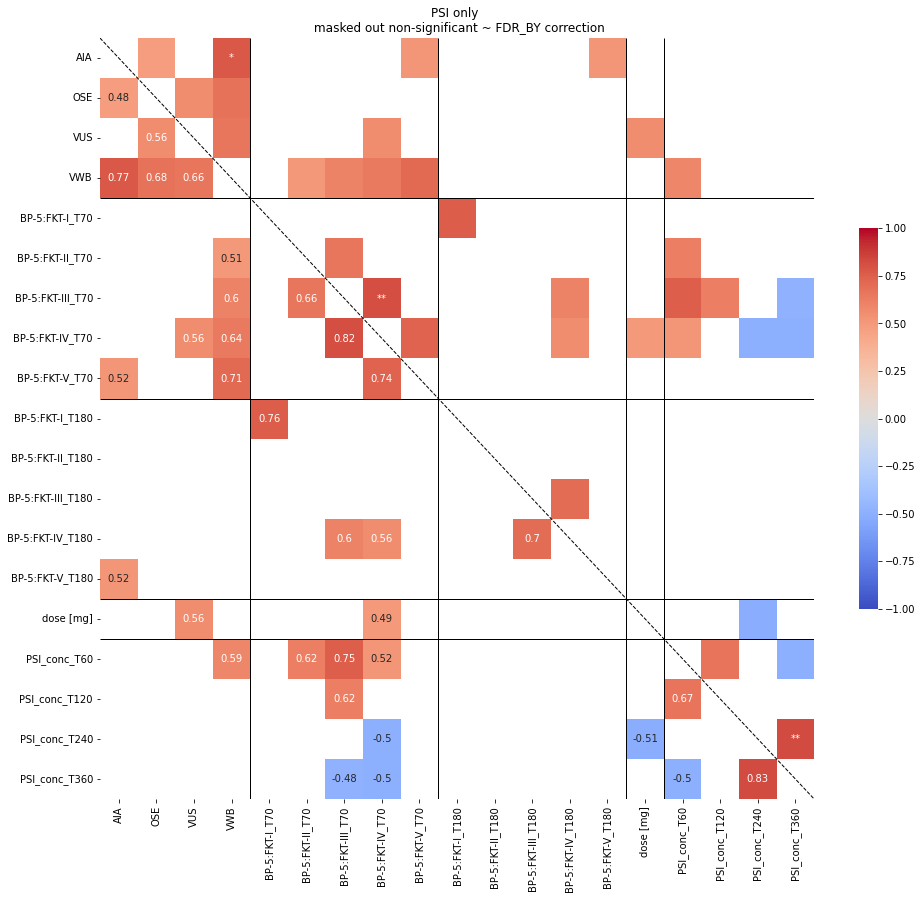

In [8]:
# only pval <= 0.05 unmasked
corr_df = (
    experience[experience["condition"] == "PSI"]
    .drop("subject", axis=1)
    .drop(
        list(experience.filter(regex="BP.*T0").columns) + ["PSI_conc_T0"],
        axis=1,
    )
)
plot_corr(
    corr_df,
    title=f"PSI only \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 15, 19, 20],
    method="spearman",
    fname="experience_PSIonly",
)

### Both psilocybin and placebo conditions

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


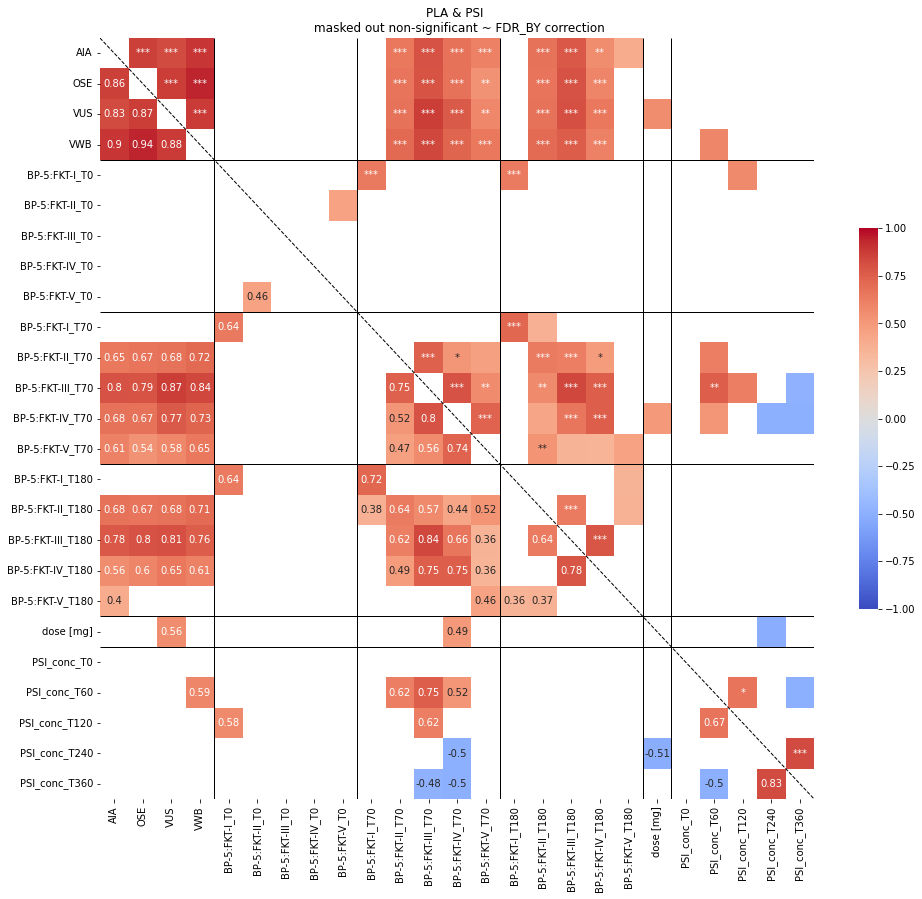

In [9]:
# only pval <= 0.05 unmasked
plot_corr(
    experience.drop("subject", axis=1),
    title=f"PLA & PSI \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 19, 20],
    method="spearman",
    fname="experience_PLAandPSI",
)

## Correlations with ASC questionnaire

In [10]:
ASC = ["AIA", "OSE", "VUS", "VWB"]

experience_asc = experience[["subject", "condition"] + ASC]
# match subjects
experience_asc = experience_asc.loc[
    experience_asc["subject"].isin(ms_stats["subject"])
]

In [11]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            asc_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_asc[
                            experience_asc["condition"] == "PSI"
                        ].set_index("subject")[asc],
                        method=method,
                    )
                    for asc in ASC
                ],
                axis=1,
            )
            asc_corrs.columns = ASC
            asc_corrs["microstate"] = ms
            asc_corrs["time"] = time
            asc_corrs = asc_corrs.dropna(axis=1)
            asc_corrs.index = asc_corrs.index.rename("stat")
            asc_corrs = asc_corrs.set_index(
                ["time", "microstate", asc_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, asc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, asc_corrs], axis=0)

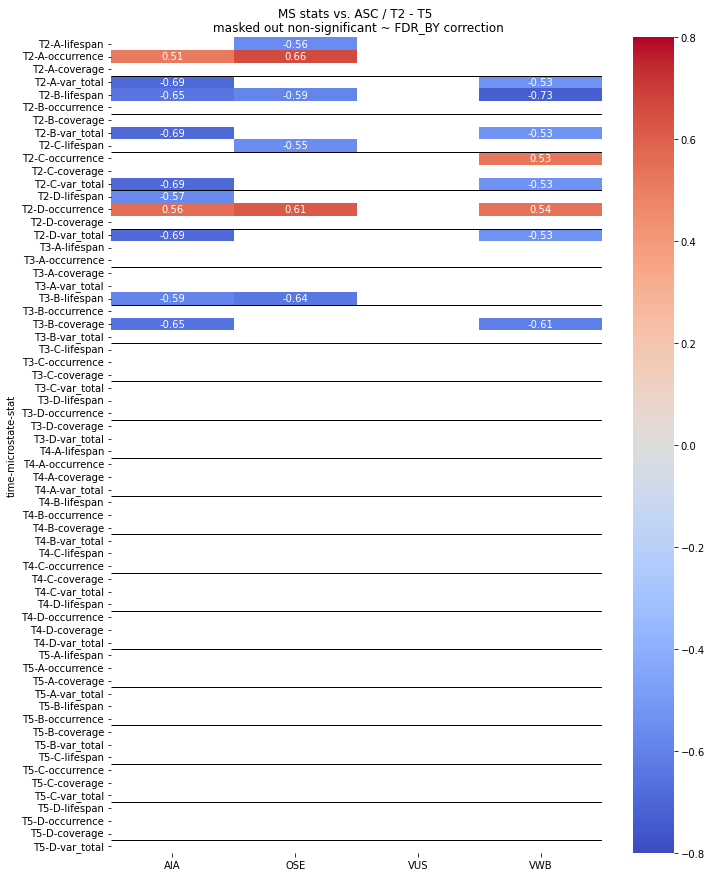

In [12]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)
sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
)
plt.title(
    f"MS stats vs. ASC / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_ASC_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_ASC_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with BPRS questionnaire

In [13]:
BP = list(experience.filter(like="BP").columns)

experience_bprs = experience[["subject", "condition"] + BP]
# match subjects
experience_bprs = experience_bprs.loc[
    experience_bprs["subject"].isin(ms_stats["subject"])
]

In [14]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            bprs_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_bprs[
                            experience_bprs["condition"] == "PSI"
                        ].set_index("subject")[bprs],
                        method=method,
                    )
                    for bprs in BP
                ],
                axis=1,
            )
            bprs_corrs.columns = BP
            bprs_corrs["microstate"] = ms
            bprs_corrs["time"] = time
            bprs_corrs = bprs_corrs.dropna(axis=1)
            bprs_corrs.index = bprs_corrs.index.rename("stat")
            bprs_corrs = bprs_corrs.set_index(
                ["time", "microstate", bprs_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, bprs_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, bprs_corrs], axis=0)

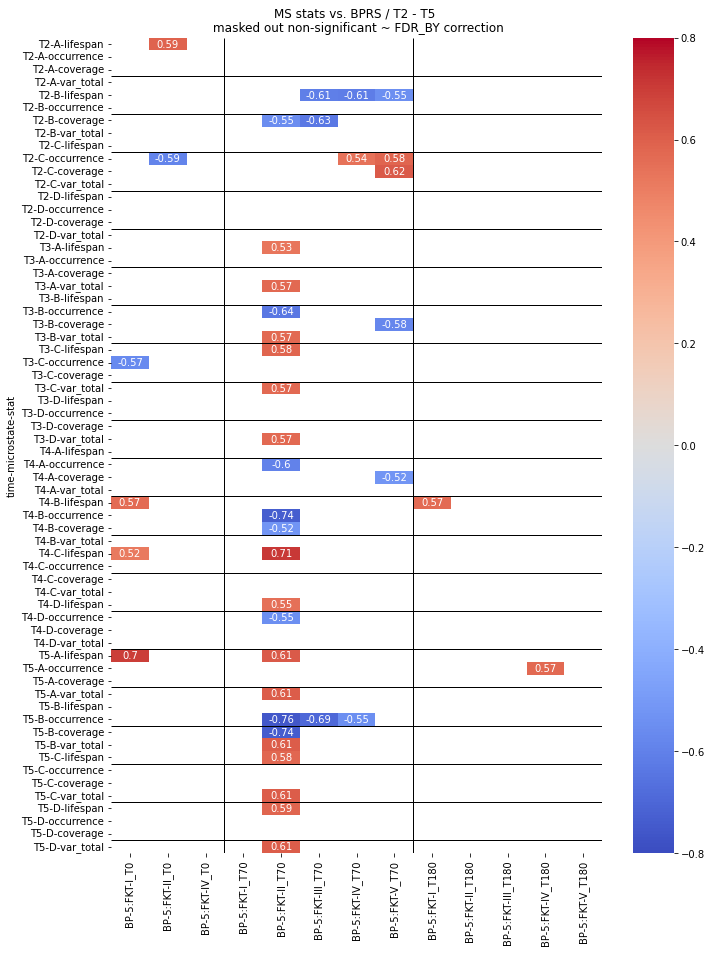

In [15]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [3, 8],
    *plt.gca().get_ylim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.title(
    f"MS stats vs. BPRS / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_BPRS_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_BPRS_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with dosage

In [16]:
CONC = list(experience.filter(like="conc").columns) + ["dose [mg]"]

experience_conc = experience[["subject", "condition"] + CONC]
# match subjects
experience_conc = experience_conc.loc[
    experience_conc["subject"].isin(ms_stats["subject"])
]

In [17]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            conc_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_conc[
                            experience_conc["condition"] == "PSI"
                        ].set_index("subject")[conc],
                        method=method,
                    )
                    for conc in CONC
                ],
                axis=1,
            )
            conc_corrs.columns = CONC
            conc_corrs["microstate"] = ms
            conc_corrs["time"] = time
            conc_corrs = conc_corrs.dropna(axis=1)
            conc_corrs.index = conc_corrs.index.rename("stat")
            conc_corrs = conc_corrs.set_index(
                ["time", "microstate", conc_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, conc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, conc_corrs], axis=0)

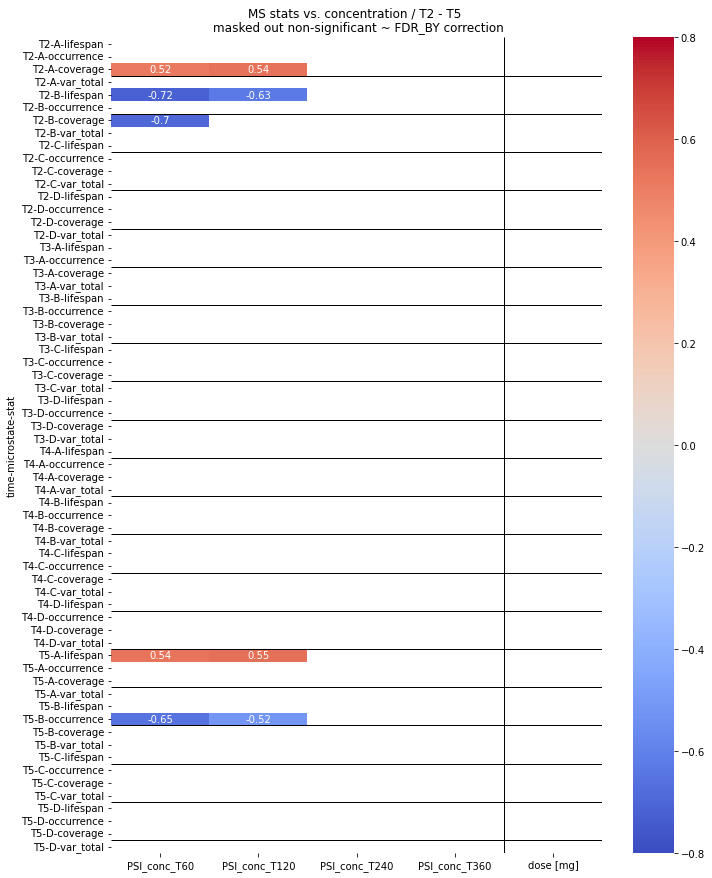

In [18]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [4], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
)
plt.title(
    f"MS stats vs. concentration / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_conc_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_conc_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with persistent effects

In [19]:
# match subjects
persisting = persisting_effs.drop("order", axis=1).loc[
    persisting_effs["subject"].isin(ms_stats["subject"])
]
EFFECTS = list(persisting.columns[2:])

In [20]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            pers_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        persisting[persisting["condition"] == "PSI"].set_index(
                            "subject"
                        )[eff],
                        method=method,
                    )
                    for eff in EFFECTS
                ],
                axis=1,
            )
            pers_corrs.columns = EFFECTS
            pers_corrs["microstate"] = ms
            pers_corrs["time"] = time
            pers_corrs = pers_corrs.dropna(axis=1)
            pers_corrs.index = pers_corrs.index.rename("stat")
            pers_corrs = pers_corrs.set_index(
                ["time", "microstate", pers_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, pers_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, pers_corrs], axis=0)

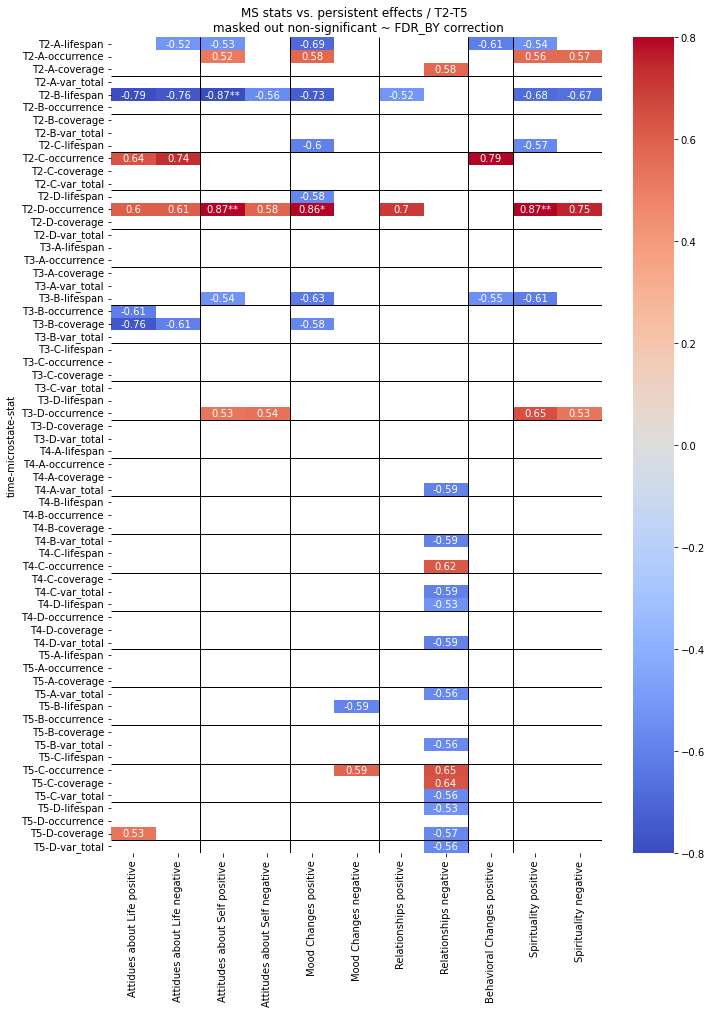

In [21]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [2, 4, 6, 8, 9],
    *plt.gca().get_ylim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.title(
    f"MS stats vs. persistent effects / T2-T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_persistent_effects_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR,
            "MSstats_w_persistent_effects_1-40filt_spearman_correlation.csv",
        )
    )

In [22]:
# group data in experience data
experience_grp = experience[experience["condition"] == "PSI"].loc[
    experience["subject"].isin(ms_stats["subject"])
]
experience_grp = experience_grp.drop(["order", "usage time"], axis=1).set_index(
    ["subject", "condition"]
)
groupings = {
    "ASC": ASC,
    "BPRS_T70": list(experience_grp.filter(like="T70").columns),
    "BPRS_T180": list(experience_grp.filter(like="T180").columns),
}

for key, val in groupings.items():
    experience_grp = pd.concat(
        [experience_grp, pd_pca(experience_grp[val], 1, key)], axis=1
    ).drop(val, axis=1)
experience_grp = experience_grp.drop(
    list(experience_grp.filter(like="T0").columns), axis=1
)
experience_grp.index = experience_grp.index.droplevel("condition")

In [23]:
persisting_effs_grp = persisting_effs[
    persisting_effs["condition"] == "PSI"
].loc[persisting_effs["subject"].isin(ms_stats["subject"])]
persisting_effs_grp = persisting_effs_grp.drop(
    ["order", "condition"]
    + list(persisting_effs_grp.filter(like="negative").columns),
    axis=1,
).set_index("subject")

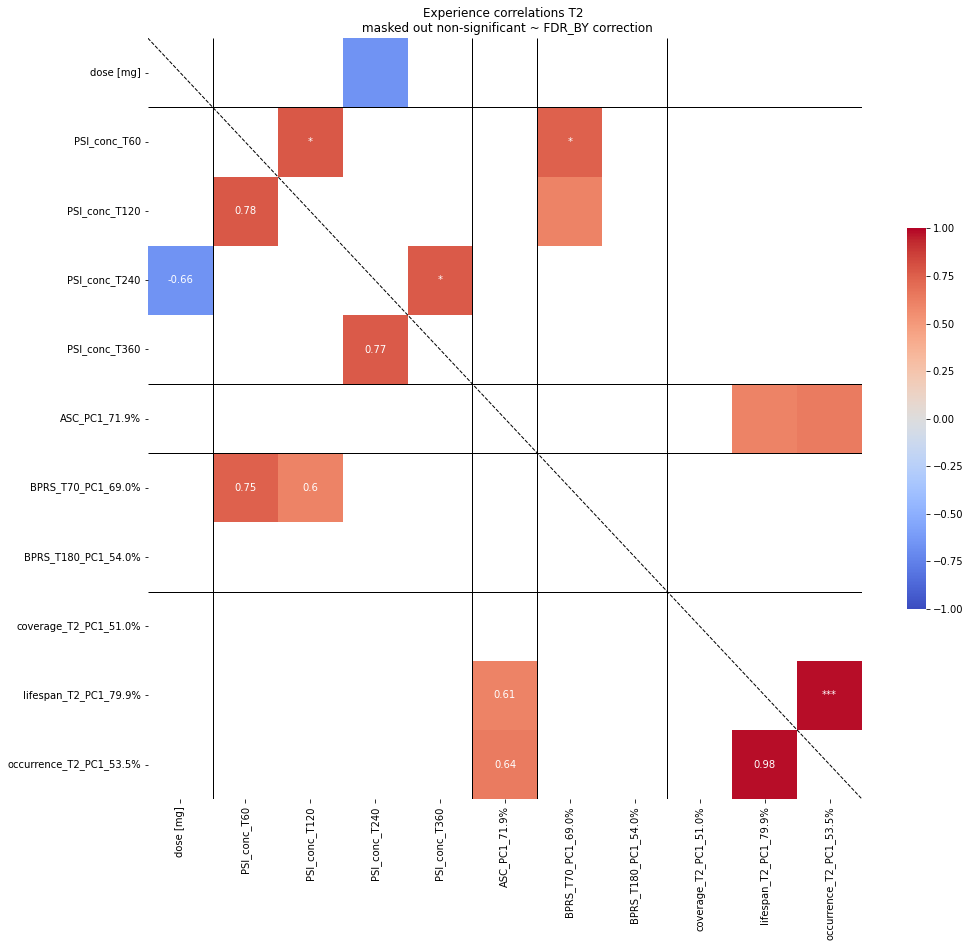

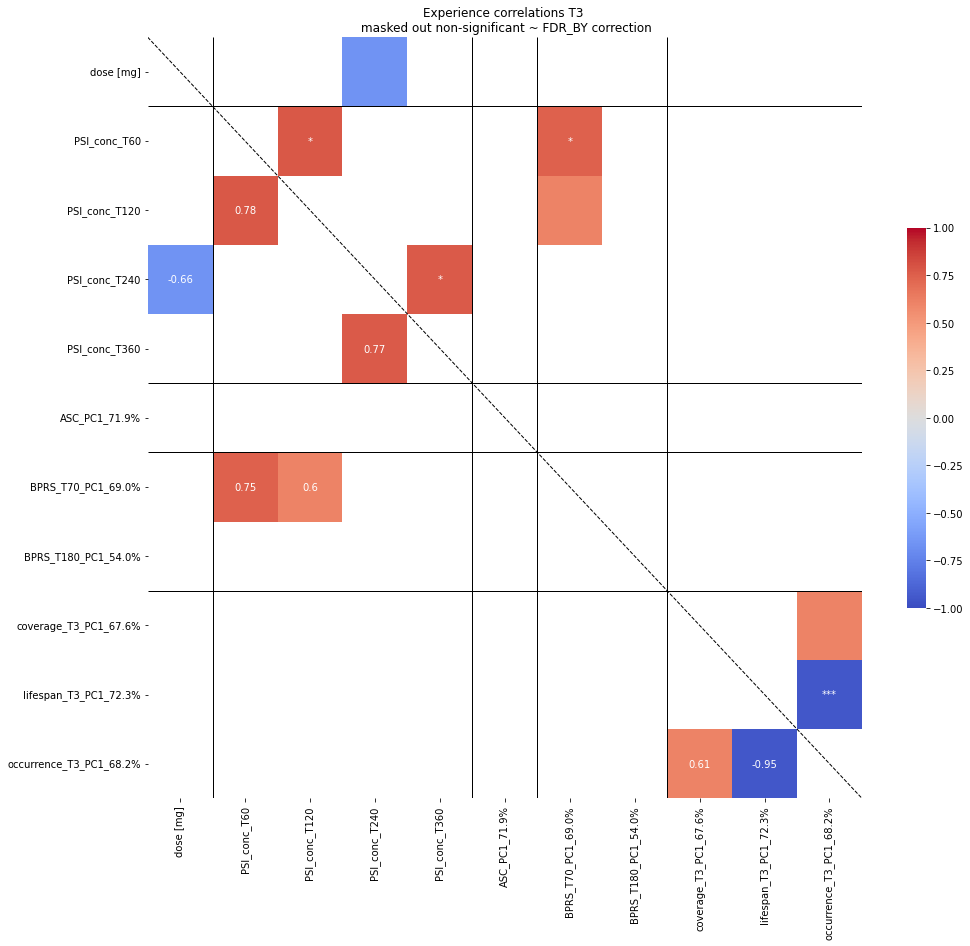

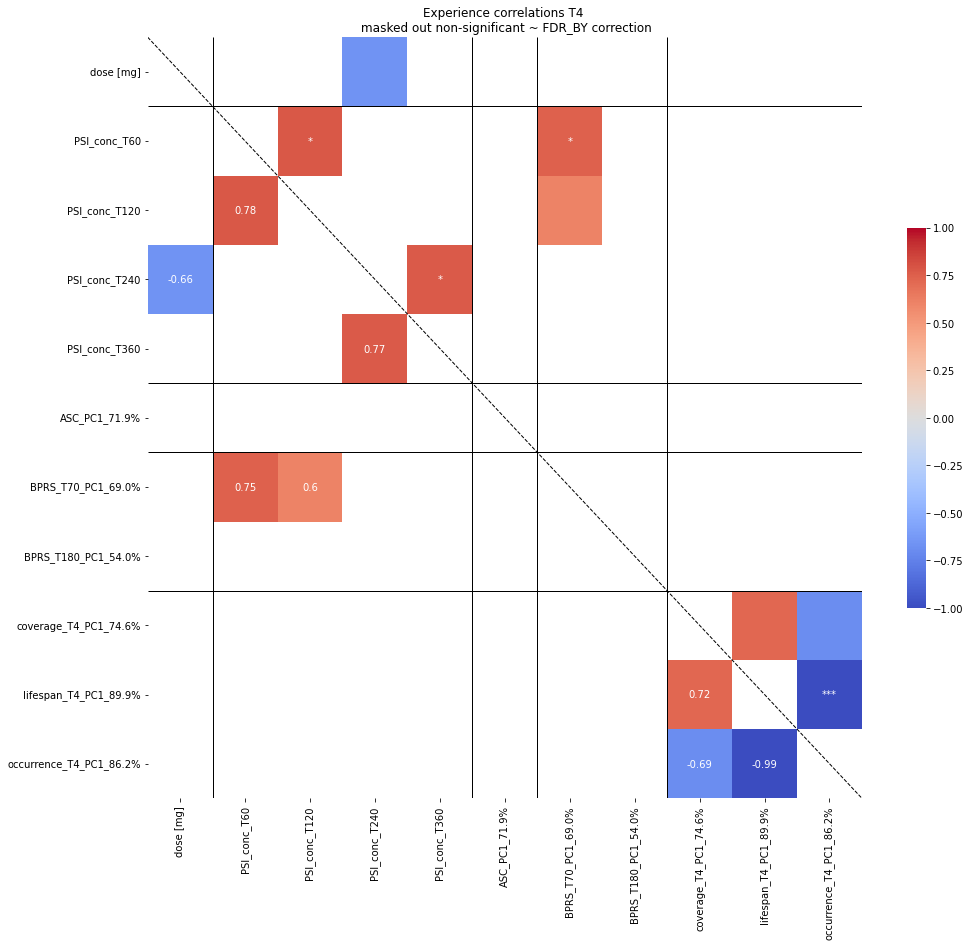

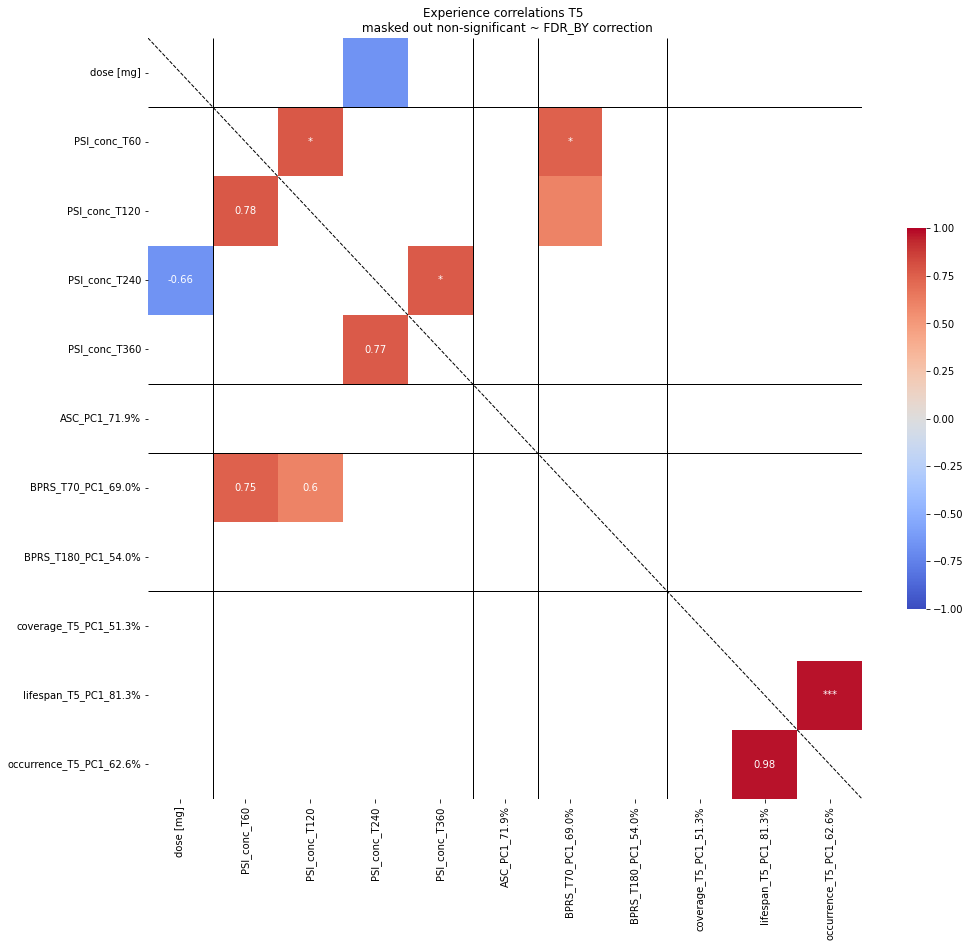

In [24]:
ms_stats_grp = (
    ms_stats[ms_stats["condition"] == "PSI"]
    .drop(["session"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp_ = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_grp[ms_stats_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp_ = pd.concat([ms_stats_grp_, pca_mat], axis=1)

    grp_corrs = pd.concat([experience_grp, ms_stats_grp_], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[1, 5, 6, 8],
        title=f"Experience correlations {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"experience_agg_{time}",
    )

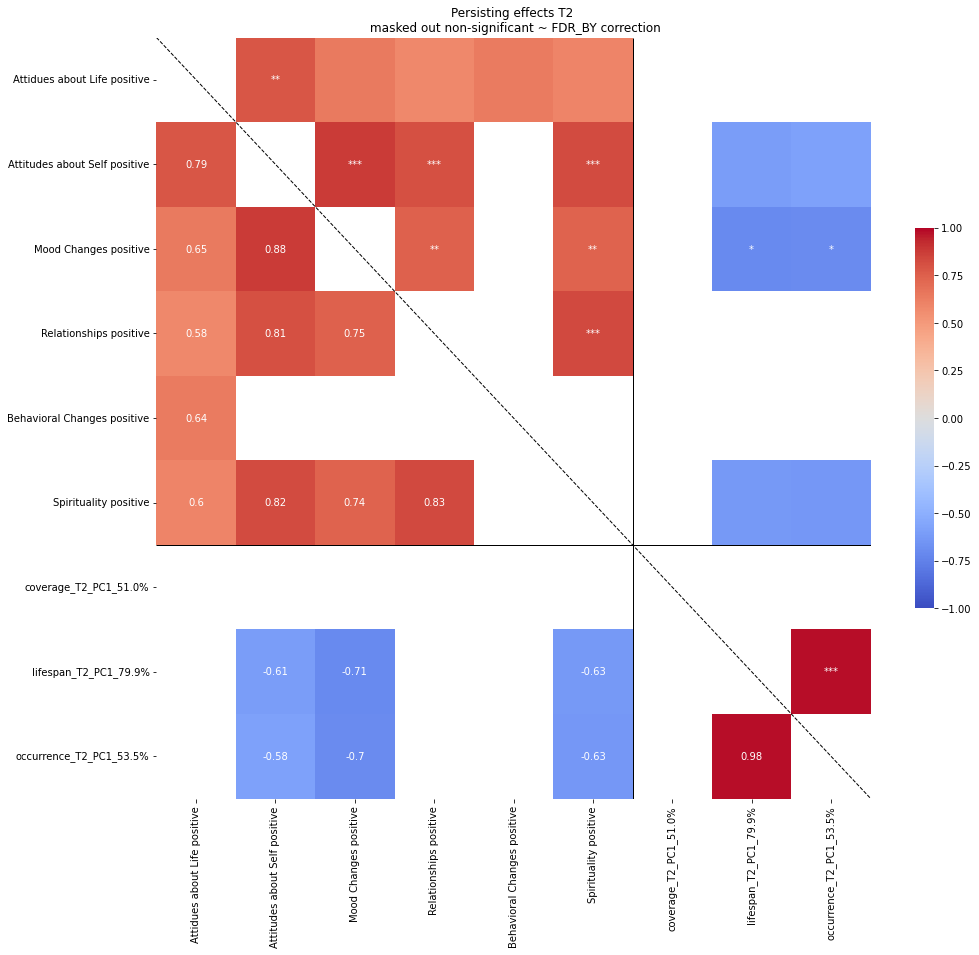

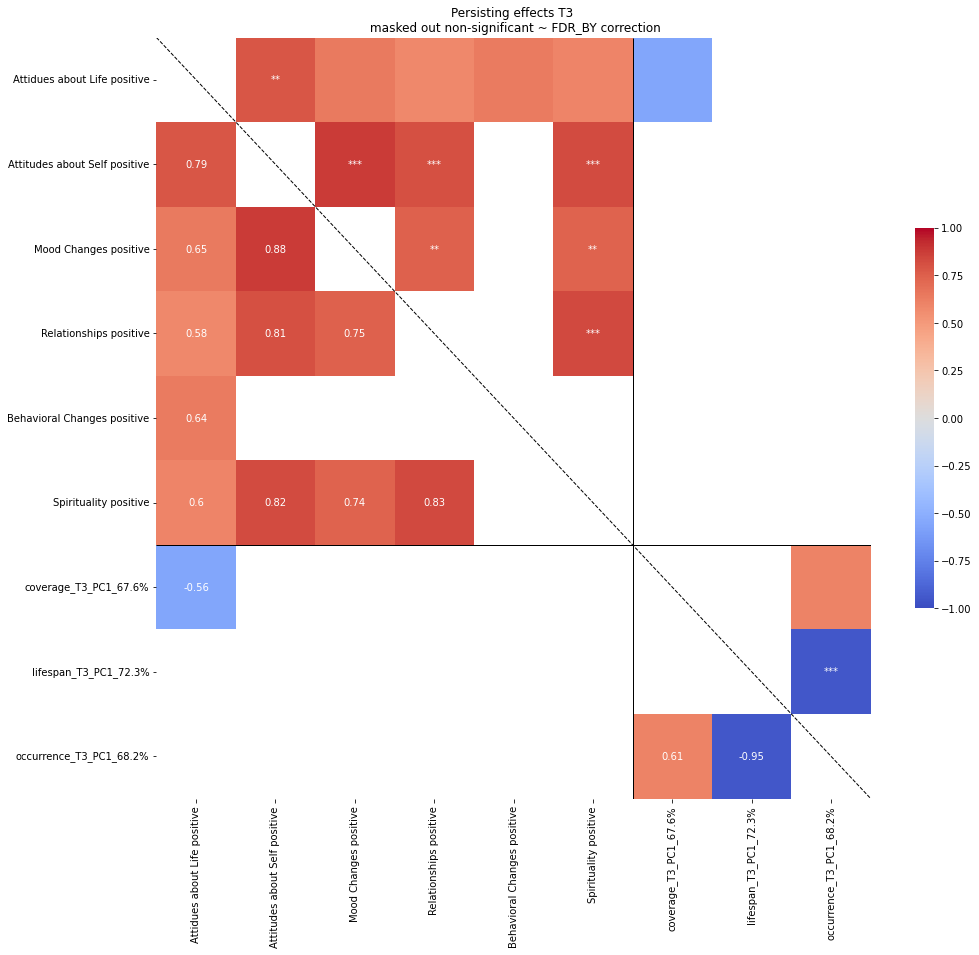

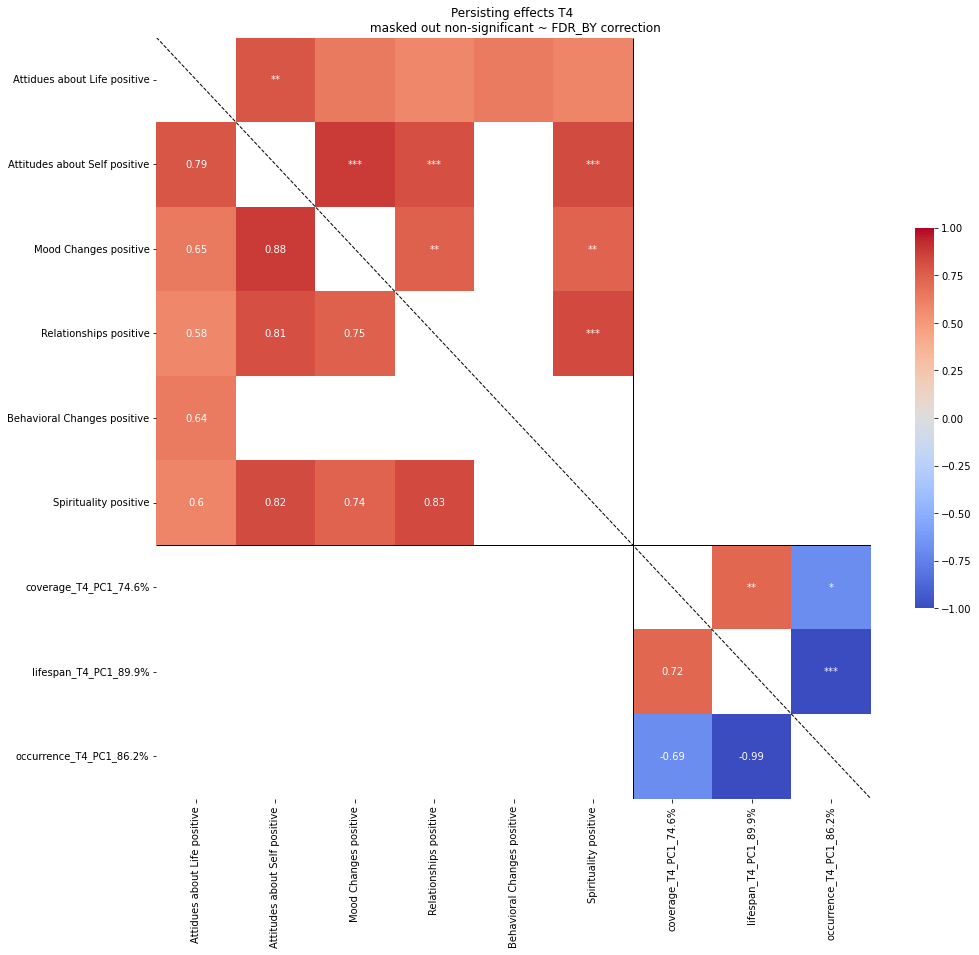

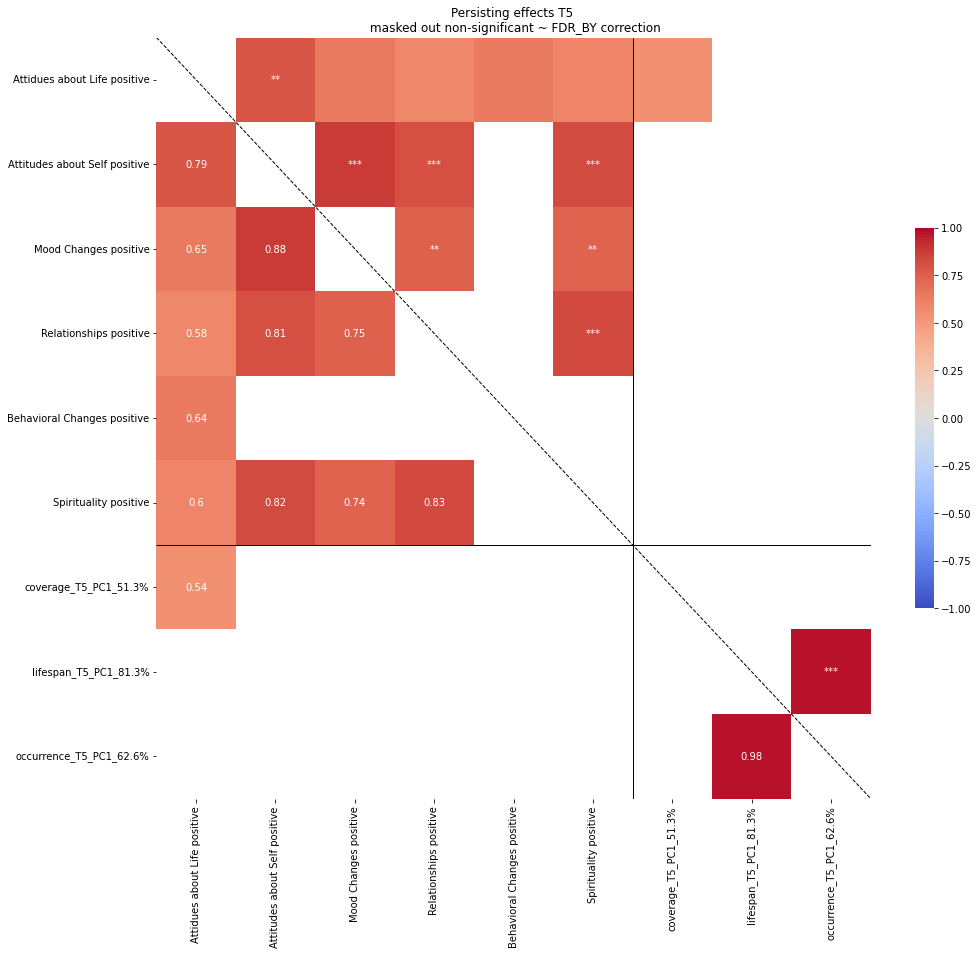

In [25]:
ms_stats_grp = (
    ms_stats[ms_stats["condition"] == "PSI"]
    .drop(["session"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp_ = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_grp[ms_stats_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp_ = pd.concat([ms_stats_grp_, pca_mat], axis=1)

    grp_corrs = pd.concat([persisting_effs_grp, ms_stats_grp_], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[6],
        title=f"Persisting effects {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"persisting_effs_agg_{time}",
    )

In [26]:
experience_asc_conc = pd.concat(
    [experience_asc, experience_conc["PSI_conc_T60"]], axis=1
)
experience_asc_conc = experience_asc_conc[
    experience_asc_conc["condition"] == "PSI"
].drop("condition", axis=1)

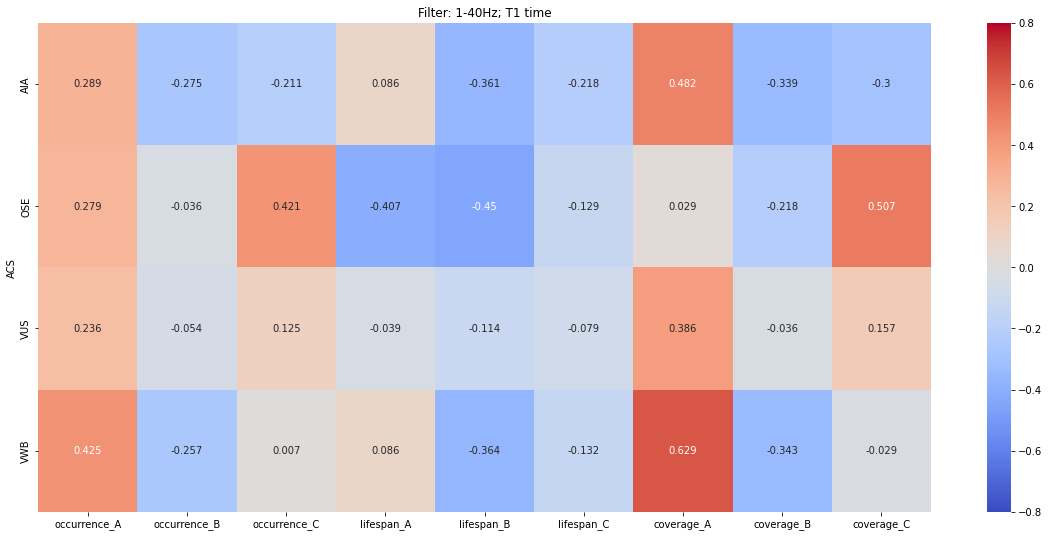

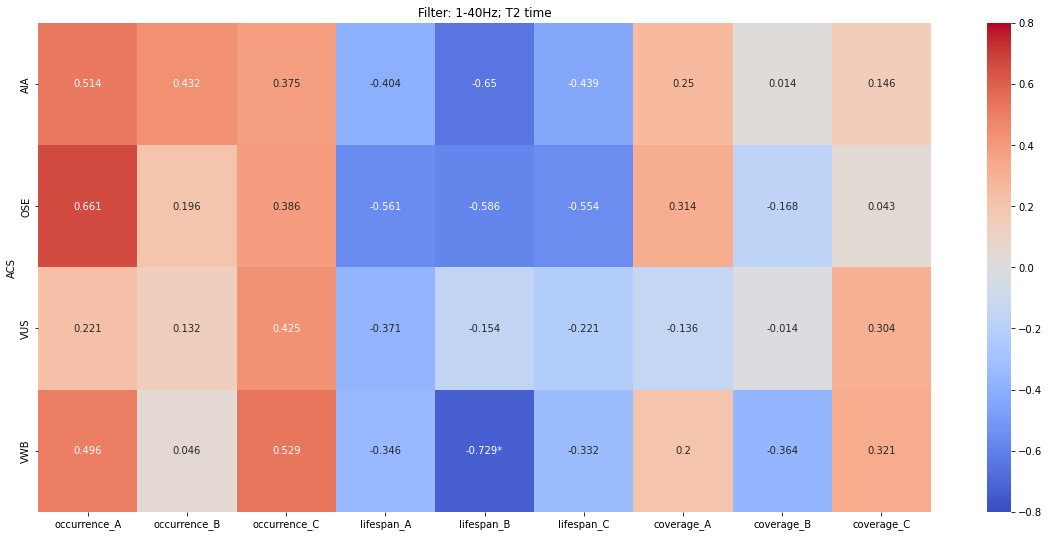

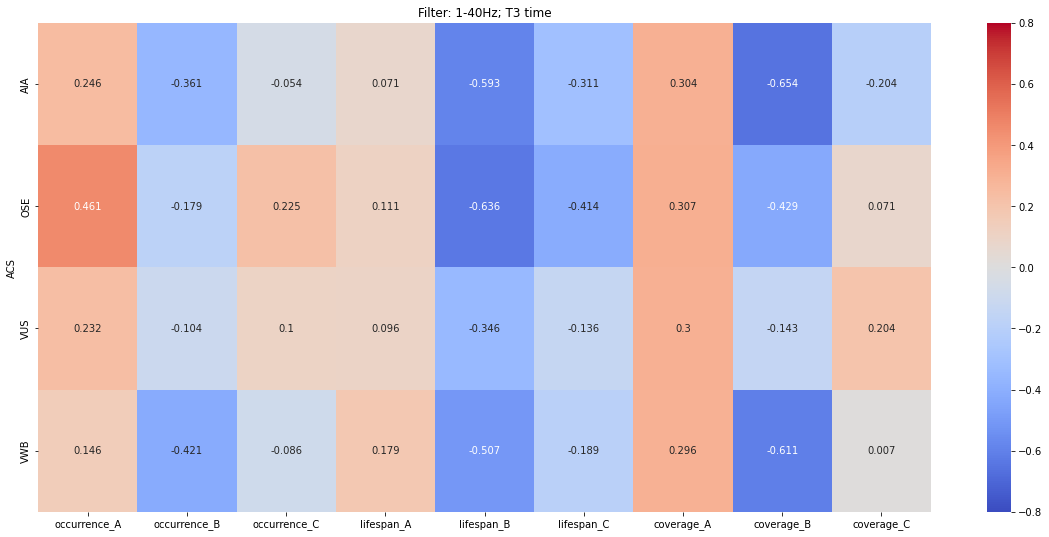

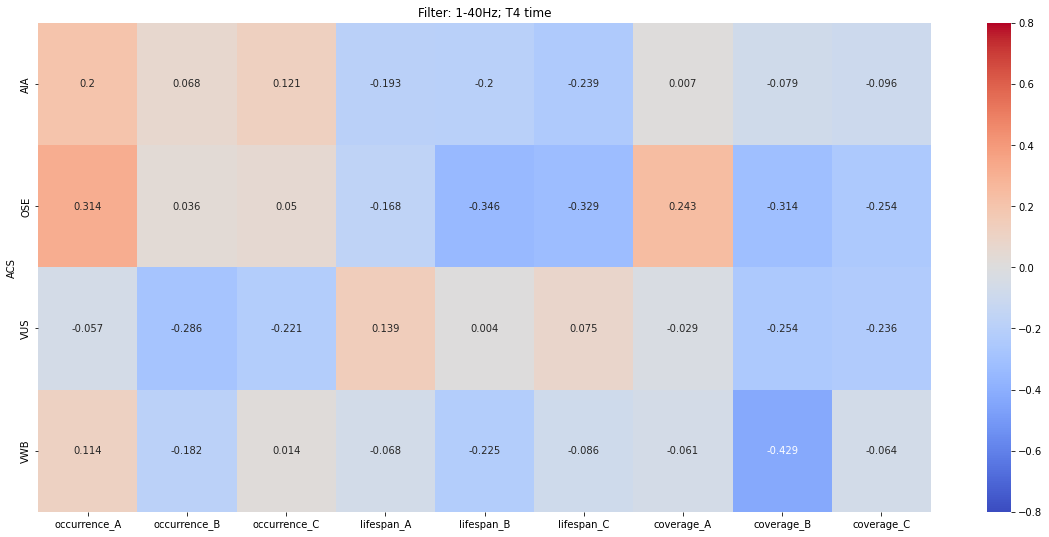

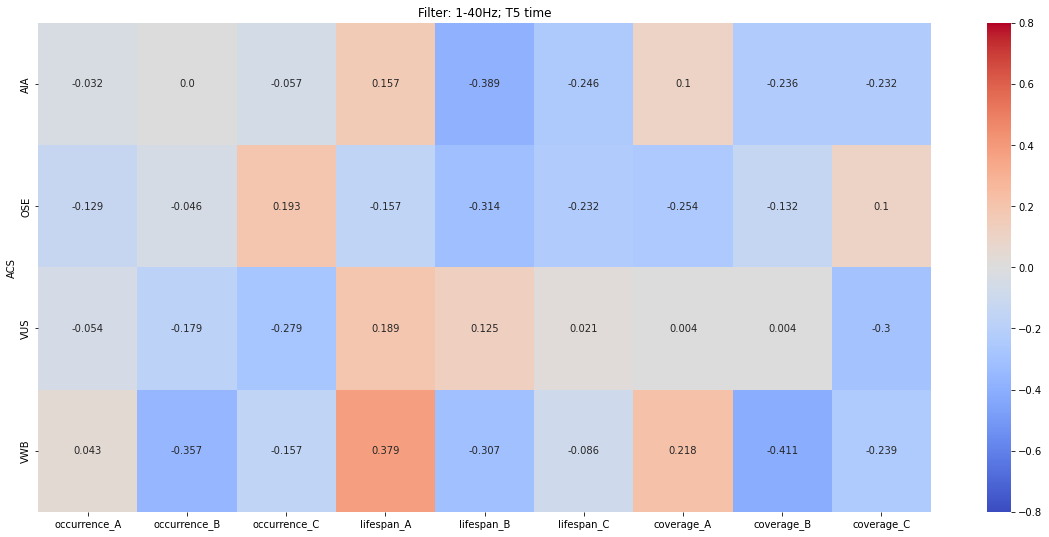

In [27]:
for time in np.unique(ms_stats["time"]):
    grand_r = pd.DataFrame()
    grand_annot = pd.DataFrame()

    for dv in ["occurrence", "lifespan", "coverage"]:
        df = ms_stats[ms_stats["condition"] == "PSI"][
            ["subject", "time", "microstate", dv]
        ]
        df = (
            df[df["time"] == time]
            .pivot(index="subject", columns="microstate", values=dv)
            .add_prefix(f"{dv}_")
        )
        df = pd.concat(
            [experience_asc_conc.reset_index(), df.reset_index()], axis=1
        )
        columns = [
            ["AIA", "OSE", "VUS", "VWB"],
            [f"{dv}_A", f"{dv}_B", f"{dv}_C"],
        ]
        corrs = pg.pairwise_corr(
            df,
            columns,
            method="spearman",
            padjust=MULTI_CORRECTION,
            alternative="two-sided",
        )
        r_vals = corrs.pivot(index="X", columns="Y", values="r")
        corr_stars = (
            corrs.pivot(index="X", columns="Y", values="p-corr")
            .round(3)
            .applymap(
                lambda x: "".join(["*" for st in PVAL_STARS.keys() if x < st])
            )
        )
        annot = r_vals.round(3).astype(str) + corr_stars
        grand_r = pd.concat([grand_r, r_vals], axis=1)
        grand_annot = pd.concat([grand_annot, annot], axis=1)
    plt.figure()
    sns.heatmap(
        grand_r, cmap="coolwarm", vmax=0.8, vmin=-0.8, annot=grand_annot, fmt=""
    )
    plt.ylabel("ACS")
    plt.xlabel("")
    plt.title(f"Filter: 1-40Hz; {time} time")
    plt.show()